In [139]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from feature_functions import *
# Import relevant machine learning models

from sklearn import decomposition, preprocessing, svm
# Dimensionality Reduction
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# Ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier

# Guassian
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Regression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

# Bayesian
from sklearn.naive_bayes import GaussianNB

# Instance Based
from sklearn.neighbors import KNeighborsClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Import relevant machine learning analyis tools
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,roc_curve,accuracy_score,auc,roc_auc_score,confusion_matrix,precision_score,recall_score,f1_score, classification_report
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.model_selection import BaseCrossValidator, GridSearchCV, train_test_split,cross_val_score,cross_validate,cross_val_predict, KFold, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline

# Standardization
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

import warnings
warnings.filterwarnings('ignore')

In [140]:
# Loading the data
df = pd.read_csv("data/EURUSDday.csv")
df.columns = ['date','open','high','low','close','volume']
df.date = pd.to_datetime(df.date, format='%d.%m.%Y %H:%M:%S.%f')
df = df.set_index(df.date)
df = df[['open','high','low','close','volume']]

# Drop elements where there is no mouvement (Market closed) like in the weekends
df = df.drop_duplicates(keep=False)
df.head(2)

,open,high,low,close,volume
date,,,,,
2003-05-04 21:00:00,1.12284,1.13009,1.12014,1.12774,1.274222e+06
2003-05-05 21:00:00,1.12728,1.14506,1.12723,1.14338,1.279672e+06


In [141]:
df['mouvement'] = (df.close - df.open)
df.head(2)

,open,high,low,close,volume,mouvement
date,,,,,,
2003-05-04 21:00:00,1.12284,1.13009,1.12014,1.12774,1.274222e+06,0.0049
2003-05-05 21:00:00,1.12728,1.14506,1.12723,1.14338,1.279672e+06,0.0161


In [142]:
df['result'] = np.append( df.close[1:].values,np.nan)
df = df.drop(df.index[[-1,-2]])

In [143]:
def f(row):
    if row['result'] >= row['close']:
        val = 1
    else:
        val = 0
    return val


In [144]:
averageKeys = [2,3,5,10,20,40,100]
df = pd.concat([df, moving_averages(df, averageKeys)],axis=1)
df = df.dropna()

df['y'] = df.apply(f, axis=1)
df = df.drop(columns=['result'])
df.head()


,open,high,low,close,volume,mouvement,MA2 open,MA2 high,MA2 low,MA2 close,...,MA20 close,MA40 open,MA40 high,MA40 low,MA40 close,MA100 open,MA100 high,MA100 low,MA100 close,y
date,,,,,,,,,,,,,,,,,,,,,
2003-09-16 21:00:00,1.11712,1.12989,1.11366,1.12804,1.340381e+06,0.01092,1.122415,1.130770,1.114445,1.12260,...,1.103126,1.117588,1.123087,1.111442,1.117453,1.140337,1.146310,1.134526,1.140748,0
2003-09-17 21:00:00,1.12773,1.13414,1.12246,1.12526,1.337392e+06,-0.00247,1.122425,1.132015,1.118060,1.12665,...,1.104791,1.117090,1.122668,1.110949,1.116919,1.140386,1.146351,1.134549,1.140723,1
2003-09-18 21:00:00,1.12500,1.13823,1.12363,1.13762,1.353038e+06,0.01262,1.126365,1.136185,1.123045,1.13144,...,1.107306,1.116545,1.122254,1.110433,1.116597,1.140363,1.146283,1.134513,1.140665,1
2003-09-21 21:00:00,1.14333,1.15031,1.14124,1.14572,1.351830e+06,0.00239,1.134165,1.144270,1.132435,1.14167,...,1.110240,1.116375,1.122219,1.110337,1.116520,1.140366,1.146342,1.134599,1.140758,0
2003-09-22 21:00:00,1.14518,1.15233,1.14348,1.14374,1.350760e+06,-0.00144,1.144255,1.151320,1.142360,1.14473,...,1.113171,1.116285,1.122186,1.110298,1.116474,1.140458,1.146358,1.134734,1.140696,1


In [145]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, shuffle=False)

# Data Standardization only on the training set
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pd.DataFrame(X_test,columns=df.columns[:-1]).head()

,open,high,low,close,volume,mouvement,MA2 open,MA2 high,MA2 low,MA2 close,...,MA20 low,MA20 close,MA40 open,MA40 high,MA40 low,MA40 close,MA100 open,MA100 high,MA100 low,MA100 close
0,-1.625242,-1.660870,-1.683038,-1.716827,-0.786273,-1.129972,-1.673487,-1.664746,-1.677040,-1.673400,...,-1.848821,-1.854579,-1.862280,-1.852705,-1.867524,-1.860386,-2.063454,-2.048452,-2.070446,-2.056572
1,-1.714302,-1.758563,-1.711356,-1.752484,-0.829446,-0.459273,-1.671087,-1.710739,-1.698094,-1.735843,...,-1.845596,-1.852146,-1.858700,-1.852548,-1.864885,-1.861291,-2.058911,-2.044410,-2.066165,-2.052780
2,-1.740432,-1.774292,-1.739477,-1.773054,-0.874794,-0.389255,-1.728728,-1.767484,-1.726329,-1.763977,...,-1.839412,-1.845390,-1.859162,-1.860900,-1.866475,-1.868591,-2.054991,-2.040352,-2.061779,-2.048610
3,-1.770673,-1.766281,-1.721582,-1.753169,-0.858194,0.239680,-1.756936,-1.771346,-1.731445,-1.764320,...,-1.828951,-1.834159,-1.866452,-1.866752,-1.868302,-1.872796,-2.050824,-2.038346,-2.057503,-2.046570
4,-1.750611,-1.775660,-1.711257,-1.760124,-0.856313,-0.099355,-1.762030,-1.772030,-1.717327,-1.757850,...,-1.817566,-1.826577,-1.870647,-1.871324,-1.867221,-1.872141,-2.048786,-2.037385,-2.054830,-2.045894


In [146]:
random_state = 43

names = ["k-Nearest Neighbors",         
         "Support Vector Machine",
         "Linear SVM",
         "RBF SVM",
         "Gaussian Process",
         "Decision Tree",
         "Extra Trees",
         "Random Forest",
         "Extra Forest",
         "AdaBoost",
         "Gaussian Naive Bayes",
         "LDA",
         "QDA",
         "Logistic Regression",
         "SGD Classifier",
         "Multilayer Perceptron",
         "Voting Classifier"
        ]

algorithms = [ KNeighborsClassifier(n_neighbors=3),
               SVC(random_state=random_state),
               SVC(kernel="linear",random_state=random_state),
               SVC(kernel="rbf",random_state=random_state),
               GaussianProcessClassifier(),
               DecisionTreeClassifier(random_state=random_state),
               ExtraTreesClassifier(random_state=random_state),
               RandomForestClassifier(random_state=random_state),
               GradientBoostingClassifier(random_state=random_state),
               AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),n_estimators=10,learning_rate=0.1,random_state=random_state),
               GaussianNB(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               LogisticRegression(random_state=random_state),
               SGDClassifier(max_iter=1000),               
               MLPClassifier(hidden_layer_sizes=(100,),momentum=0.9,solver='sgd',random_state=random_state),
               VotingClassifier(estimators=[('log', LogisticRegression()), ('SVM',SVC(C=1000)), ('MLP', MLPClassifier(hidden_layer_sizes=(100,)))], voting='hard')
              ]


In [147]:
def compare_models(X_train,y_train,algorithms):
    data_copy=[]
    for model in algorithms:
        model.fit(X_train,y_train.values)
        pred_test = model.predict(X_test)
        data_copy.append(metrics.accuracy_score(pred_test, y_test))

    models_df = pd.DataFrame(data_copy, index=names)   
    models_df.columns=['Accuracy']
    return models_df

In [127]:
compare_models(X_train,y_train,algorithms).sort_values(by='Accuracy',ascending=False)

,Accuracy
k-Nearest Neighbors,0.524876
Support Vector Machine,0.500000
Linear SVM,0.502488
RBF SVM,0.500000
Gaussian Process,0.526119
Decision Tree,0.507463
Extra Trees,0.506219
Random Forest,0.501244
Extra Forest,0.501244
AdaBoost,0.512438


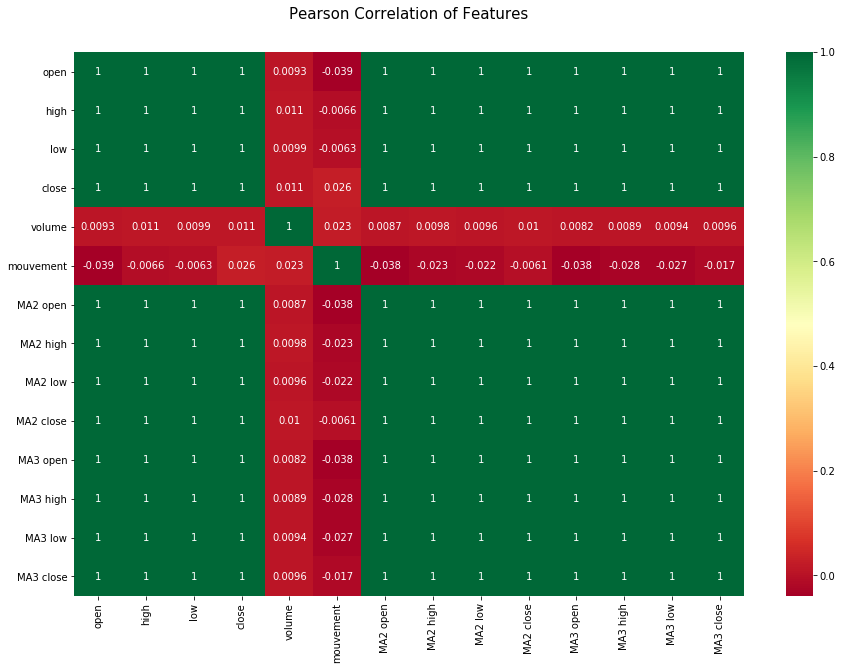

In [128]:
sns.heatmap(df[df.columns[:14]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf().set_size_inches(15, 10)
plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()


In [149]:
model = ExtraTreesClassifier(n_estimators=100,random_state=random_state)
model.fit(df.iloc[:,:-1], df.iloc[:,-1])
pd.DataFrame(pd.Series(model.feature_importances_, index=df.columns[:-1]).sort_values(ascending=False),columns=['importance'])


,importance
mouvement,0.209251
MA20 high,0.201931
volume,0.198791
close,0.195660
MA2 close,0.194368


In [150]:
model = RandomForestClassifier(n_estimators=100,random_state=random_state)
model.fit(df.iloc[:,:-1], df.iloc[:,-1])
pd.DataFrame(pd.Series(model.feature_importances_, index=df.columns[:-1]).sort_values(ascending=False),columns=['importance'])


,importance
mouvement,0.216058
volume,0.205950
MA20 high,0.204021
close,0.190085
MA2 close,0.183885


Open high low close are highly correlated

In [148]:
df = df.drop(columns=['open','high','low'])
df.head(1)
df = df[['mouvement','volume','close','MA2 close','MA20 high','y']]


In [152]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.1, shuffle=False)

# # Data Standardization only on the training set
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
results = compare_models(X_train,y_train,algorithms)

In [153]:
results.sort_values(by='Accuracy',ascending=False)

,Accuracy
k-Nearest Neighbors,0.554726
LDA,0.544776
QDA,0.542289
RBF SVM,0.524876
Support Vector Machine,0.524876
Gaussian Naive Bayes,0.522388
Multilayer Perceptron,0.522388
SGD Classifier,0.522388
Logistic Regression,0.522388
Voting Classifier,0.522388


In [106]:
y_test.shape

(42,)

In [100]:
best_algos = [VotingClassifier(estimators=[('log', LogisticRegression()), ('SVM',SVC(C=1000)), ('MLP', MLPClassifier(hidden_layer_sizes=(100,)))], voting='hard'),
            LogisticRegression(random_state=random_state),    
             GaussianProcessClassifier(),

             ]

best_algos_names = ['Voting Classifier', 'Logistic Regression', 'Gaussian Process']


In [101]:
predicitions = []
for model in best_algos:
    model.fit(X_train,y_train)
    predicitions.append( model.predict(X_test))

predictions_df = pd.DataFrame(predicitions, index=best_algos_names)   
predictions_df.loc['sum'] = predictions_df.sum(axis=0) 
predictions_df


,0,1,2,3,4,5,6,7,8,9,...,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235
Voting Classifier,1,1,0,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
Logistic Regression,1,1,0,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
Gaussian Process,1,1,0,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,0
sum,3,3,0,3,3,3,3,3,0,3,...,3,3,3,3,3,3,3,3,2,2


In [102]:
voted_predictions =[]
for i in range(predictions_df.shape[1]):
    if predictions_df.iloc[predictions_df.shape[0] - 1,i] >= predictions_df.shape[0]/2 :
        voted_predictions.append(1.)
    else : 
        voted_predictions.append(0.)
        
voted_predictions = np.array(voted_predictions)

In [103]:
metrics.accuracy_score(voted_predictions, y_test)

0.5008090614886731